In [1]:
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
import fcalc

## Binarized data

In [2]:
df = pd.read_csv("Breast_cancer_data.csv")
df['diagnosis'] = [x == 1 for x in df['diagnosis']]
df.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,False
1,20.57,17.77,132.90,1326.0,0.08474,False
2,19.69,21.25,130.00,1203.0,0.10960,False
3,11.42,20.38,77.58,386.1,0.14250,False
4,20.29,14.34,135.10,1297.0,0.10030,False


In [3]:
quartiles = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
vals = []

for i in df.columns.values[:-1]:
    qs = []
    for j in quartiles:
        qs.append(df[i].quantile(j))
    vals.append(qs)
    
def quantiles(x, lis):
    for i in lis:
        if x > i:
            return f'>{i}'

In [4]:
df['mean_radius'] = df['mean_radius'].apply(lambda x: quantiles(x = x, lis = vals[0]))
df['mean_texture'] = df['mean_texture'].apply(lambda x: quantiles(x = x, lis = vals[1]))
df['mean_perimeter'] = df['mean_perimeter'].apply(lambda x: quantiles(x = x, lis = vals[2]))
df['mean_area'] = df['mean_area'].apply(lambda x: quantiles(x = x, lis = vals[3]))
df['mean_smoothness'] = df['mean_smoothness'].apply(lambda x: quantiles(x = x, lis = vals[4]))

In [5]:
column_names = df.columns.values[:-1]
df.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,>17.067999999999998,>9.71,>111.68,>915.0600000000003,>0.11482,False
1,>19.53,>16.84,>129.1,>1177.3999999999999,>0.08420599999999999,False
2,>19.53,>19.968,>129.1,>1177.3999999999999,>0.1075,False
3,>11.366,>19.968,>77.36,>321.6,>0.11482,False
4,>19.53,>14.078,>129.1,>1177.3999999999999,>0.099338,False


In [6]:
X = pd.get_dummies(data=df, prefix=column_names).astype(bool)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    X.drop(["diagnosis"], axis=1), 
                                                    X["diagnosis"], 
                                                    test_size=0.3, 
                                                    random_state=1337, 
                                                    stratify=X["diagnosis"], 
                                        )

In [8]:
from sklearn.model_selection import KFold, StratifiedKFold

X_train_matrix = X_train.values

kfold = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

for i in ['standard', 'standard-support', 'ratio-support']:
    score_accuracy = []
    
    for array1, array2 in kfold.split(X_train_matrix, y_train):   
        x_train_cv = X_train_matrix[array1]
        y_train_cv = np.array(y_train)[list(array1)]

        x_test_cv = X_train_matrix[array2]
        y_test_cv = np.array(y_train)[list(array2)]

        bin_cls = fcalc.classifier.BinarizedBinaryClassifier(x_train_cv, y_train_cv, method=i)
        bin_cls.predict(x_test_cv)
        y_pred_cv = bin_cls.predictions

        score_accuracy.append(accuracy_score(y_test_cv, y_pred_cv))
    
    print(f'{i}: mean: {np.array(score_accuracy).mean()}, max: {max(score_accuracy)}, min: {min(score_accuracy)}')
    
    
bin_cls = fcalc.classifier.BinarizedBinaryClassifier(X_train_matrix, y_train, method='ratio-support')
bin_cls.predict(X_test.values)
y_pred = bin_cls.predictions

print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

accuracy_fcalc = accuracy_score(y_test, y_pred)
f1_fcalc = f1_score(y_test, y_pred)

standard: mean: 0.8718987341772151, max: 0.9, min: 0.8125
standard-support: mean: 0.8668670886075949, max: 0.8875, min: 0.8125
ratio-support: mean: 0.8717088607594936, max: 0.9375, min: 0.8227848101265823
0.8888888888888888
0.9035532994923858


## Pattern structures

In [9]:
df = pd.read_csv("Breast_cancer_data.csv")
df['diagnosis'] = [x == 1 for x in df['diagnosis']]
column_names = df.columns.values[:-1]
df.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,False
1,20.57,17.77,132.90,1326.0,0.08474,False
2,19.69,21.25,130.00,1203.0,0.10960,False
3,11.42,20.38,77.58,386.1,0.14250,False
4,20.29,14.34,135.10,1297.0,0.10030,False


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df.drop(["diagnosis"], axis=1), 
                                                    df["diagnosis"], 
                                                    test_size=0.3, 
                                                    random_state=1337,
                                                    stratify=X["diagnosis"],
                                        )

In [11]:
X_train_matrix = X_train.values

kfold = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

for i in ['standard', 'standard-support', 'ratio-support']:
    score_accuracy = []
    
    for array1, array2 in kfold.split(X_train_matrix, y_train):   
        x_train_cv = X_train_matrix[array1]
        y_train_cv = np.array(y_train)[list(array1)]

        x_test_cv = X_train_matrix[array2]
        y_test_cv = np.array(y_train)[list(array2)]
        
        pat_cls = fcalc.classifier.PatternBinaryClassifier(x_train_cv, y_train_cv)
        pat_cls.predict(x_test_cv)
        
        y_pred_cv = pat_cls.predictions

        score_accuracy.append(accuracy_score(y_test_cv, y_pred_cv))
    
    print(f'{i}: mean: {np.array(score_accuracy).mean()}, max: {max(score_accuracy)}, min: {min(score_accuracy)}')

standard: mean: 0.9095569620253166, max: 0.925, min: 0.8875
standard-support: mean: 0.9095569620253166, max: 0.925, min: 0.8875
ratio-support: mean: 0.9095569620253166, max: 0.925, min: 0.8875


In [12]:
pat_cls = fcalc.classifier.PatternBinaryClassifier(X_train_matrix, y_train)
pat_cls.predict(X_test.values)

y_pred = pat_cls.predictions

y_pred = [np.random.choice([0,1]) if i == -1 else i for i in y_pred]
accuracy_fcalc_stru = accuracy_score(y_test, y_pred)
f1_fcalc_stru = f1_score(y_test, y_pred)


# Другие модели

In [13]:
df = pd.read_csv("Breast_cancer_data.csv")
df.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df.drop(["diagnosis"], axis=1), 
                                                    df["diagnosis"], 
                                                    test_size=0.3, 
                                                    random_state=1337, 
                                                    stratify=X["diagnosis"],
                                        )

In [15]:
from sklearn.preprocessing import OrdinalEncoder
from scipy import sparse as sp

def prepare_features_for_logic(data: pd.DataFrame):
    
    real_columns = ['mean_radius','mean_texture','mean_perimeter','mean_area','mean_smoothness']
    
    X_real = data[real_columns].values    
    feature_matrix = np.vstack(X_real) 
    
    return feature_matrix

X_train_dense = prepare_features_for_logic(X_train)
X_test_dense = prepare_features_for_logic(X_test)

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Дерево решений
clf = DecisionTreeClassifier(max_depth=4, class_weight="balanced").fit(X_train_dense, y_train)
y_pred = clf.predict(X_test_dense)
print(f1_score(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

accuracy_tree = accuracy_score(y_test, y_pred)
f1_tree = f1_score(y_test, y_pred)

0.9320388349514562
0.9181286549707602


In [17]:
# Случайный лес

param_grid = {
    "n_estimators": [10, 50, 100],
    "min_samples_leaf": [1, 2, 3, 5],
    "max_samples": [0.3, None]
}
param_grid

scores = ["f1", "accuracy"]

for score in scores:
    print("# Tuning for %s" % score)
    print()
    # loo = LeaveOneOut()

    clf = GridSearchCV(RandomForestClassifier(n_jobs=-1, random_state=100, class_weight='balanced_subsample'), 
                       param_grid, scoring=score, verbose=1, cv=3)

    clf.fit(X_train_dense, y_train)

    print("Best params on dev set:")
    print(clf.best_params_)
    
    print("Scores on development set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']

    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
    best_model = clf.best_estimator_
    best_model.fit(X_train_dense, y_train)
    
y_pred = best_model.predict(X_test_dense)
print(f1_score(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

accuracy_forest = accuracy_score(y_test, y_pred)
f1_forest = f1_score(y_test, y_pred)

# Tuning for f1

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params on dev set:
{'max_samples': 0.3, 'min_samples_leaf': 1, 'n_estimators': 50}
Scores on development set:
0.923 (+/-0.019) for {'max_samples': 0.3, 'min_samples_leaf': 1, 'n_estimators': 10}
0.933 (+/-0.031) for {'max_samples': 0.3, 'min_samples_leaf': 1, 'n_estimators': 50}
0.931 (+/-0.024) for {'max_samples': 0.3, 'min_samples_leaf': 1, 'n_estimators': 100}
0.921 (+/-0.020) for {'max_samples': 0.3, 'min_samples_leaf': 2, 'n_estimators': 10}
0.927 (+/-0.024) for {'max_samples': 0.3, 'min_samples_leaf': 2, 'n_estimators': 50}
0.929 (+/-0.026) for {'max_samples': 0.3, 'min_samples_leaf': 2, 'n_estimators': 100}
0.930 (+/-0.030) for {'max_samples': 0.3, 'min_samples_leaf': 3, 'n_estimators': 10}
0.922 (+/-0.026) for {'max_samples': 0.3, 'min_samples_leaf': 3, 'n_estimators': 50}
0.925 (+/-0.028) for {'max_samples': 0.3, 'min_samples_leaf': 3, 'n_estimators': 100}
0.918 (+/-0.024) for {'max_samples': 0.

In [18]:
from sklearn.neighbors import KNeighborsClassifier

In [19]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from scipy import sparse as sp

# Не все классификаторы умеют обращаться с категориальными признаками. 
def prepare_features_for_logreg(data: pd.DataFrame, real_scaler=None):
    
    real_columns = ['mean_radius','mean_texture','mean_perimeter','mean_area','mean_smoothness']
    
    # real-valued features
    if real_scaler is None:
        stsc = StandardScaler()
        stsc.fit(data[real_columns])
    else:
        stsc = real_scaler
    X_real = stsc.transform(data[real_columns])
    feature_matrix = np.vstack(X_real)
    
    return feature_matrix

X_train_sparse = prepare_features_for_logreg(X_train)
X_test_sparse = prepare_features_for_logreg(X_test)

X_train_sparse.shape, X_test_sparse.shape

((398, 5), (171, 5))

In [20]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_train_sparse, y_train)

KNeighborsClassifier(n_neighbors=1)

In [21]:
y_pred = neigh.predict(X_test_sparse)
print(f1_score(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

accuracy_knn = accuracy_score(y_test, y_pred)
f1_knn = f1_score(y_test, y_pred)

0.9389671361502347
0.9239766081871345


In [22]:
from sklearn.linear_model import LogisticRegression

clf_linear = LogisticRegression(C=0.99, class_weight="balanced", 
                                solver="saga", penalty="l1")
clf_linear.fit(X_train_sparse, y_train)

y_pred = clf_linear.predict(X_test_sparse)

print(f1_score(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

accuracy_log = accuracy_score(y_test, y_pred)
f1_log = f1_score(y_test, y_pred)

0.9674418604651163
0.9590643274853801


C:\Users\777sa\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [23]:
from xgboost import XGBClassifier
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train_dense, y_train)
y_pred = model.predict(X_test_dense)
print(f1_score(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

accuracy_xgb = accuracy_score(y_test, y_pred)
f1_xgb = f1_score(y_test, y_pred)

0.9716981132075471
0.9649122807017544


In [24]:
from catboost import CatBoostClassifier
clf = CatBoostClassifier(
    iterations=10,
    #verbose=5,
)

clf.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
)

y_pred = clf.predict(X_test)
print(f1_score(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

accuracy_cat = accuracy_score(y_test, y_pred)
f1_cat = f1_score(y_test, y_pred)

Learning rate set to 0.187103
0:	learn: 0.6088768	test: 0.6033559	best: 0.6033559 (0)	total: 151ms	remaining: 1.36s
1:	learn: 0.5404485	test: 0.5322506	best: 0.5322506 (1)	total: 154ms	remaining: 615ms
2:	learn: 0.4871087	test: 0.4758042	best: 0.4758042 (2)	total: 156ms	remaining: 364ms
3:	learn: 0.4376584	test: 0.4244045	best: 0.4244045 (3)	total: 159ms	remaining: 239ms
4:	learn: 0.4030945	test: 0.3830265	best: 0.3830265 (4)	total: 163ms	remaining: 163ms
5:	learn: 0.3741327	test: 0.3531417	best: 0.3531417 (5)	total: 166ms	remaining: 110ms
6:	learn: 0.3473431	test: 0.3227216	best: 0.3227216 (6)	total: 169ms	remaining: 72.3ms
7:	learn: 0.3246997	test: 0.2971962	best: 0.2971962 (7)	total: 173ms	remaining: 43.3ms
8:	learn: 0.3071884	test: 0.2798720	best: 0.2798720 (8)	total: 176ms	remaining: 19.5ms
9:	learn: 0.2906570	test: 0.2633131	best: 0.2633131 (9)	total: 178ms	remaining: 0us

bestTest = 0.263313096
bestIteration = 9

0.9674418604651163
0.9590643274853801


In [25]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()

model.fit(X_train_dense, y_train)
y_pred = model.predict(X_test_dense)

print(f1_score(y_test, y_pred))
print(accuracy_score(y_test, y_pred))


accuracy_bay = accuracy_score(y_test, y_pred)
f1_bay = f1_score(y_test, y_pred)

0.948356807511737
0.935672514619883


# Итоги

Accuracy
-------------------
Fcalc_Binarized: 0.89
Tree: 0.92
KNN: 0.92
Naive_B: 0.94
Fcalc_Structure: 0.95
Log_Reg: 0.96
Catboost: 0.96
RandForest: 0.96
XGB: 0.96


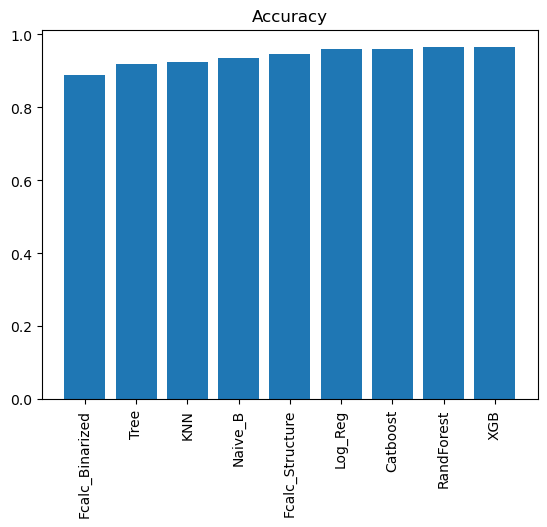

In [26]:
import operator
all_accs = [ accuracy_fcalc
            ,accuracy_fcalc_stru
            ,accuracy_tree
            ,accuracy_forest
            ,accuracy_knn
            ,accuracy_log
            ,accuracy_xgb
            ,accuracy_cat
            ,accuracy_bay]
all_accs_names = [ 
             'Fcalc_Binarized'
            ,'Fcalc_Structure'
            ,'Tree'
            ,'RandForest'
            ,'KNN'
            ,'Log_Reg'
            ,'XGB'
            ,'Catboost'
            ,'Naive_B']

my_dict = dict(zip(all_accs_names, all_accs))
sorted_accs = dict(sorted(my_dict.items(), key=operator.itemgetter(1)))

lists = sorted_accs.items() 
x, y = zip(*lists)

print('Accuracy\n-------------------')
for i in lists:
    print(i[0],': ', round(i[1],2), sep='')
    
plt.bar(x = x, height=y)
plt.xticks(rotation=90)
plt.title('Accuracy');

F1_Score
-------------------
Fcalc_Binarized: 0.9
Tree: 0.93
KNN: 0.94
NaiveB: 0.95
Fcalc_Structure: 0.96
Log_Reg: 0.97
Catboost: 0.97
RandForest: 0.97
XGB: 0.97


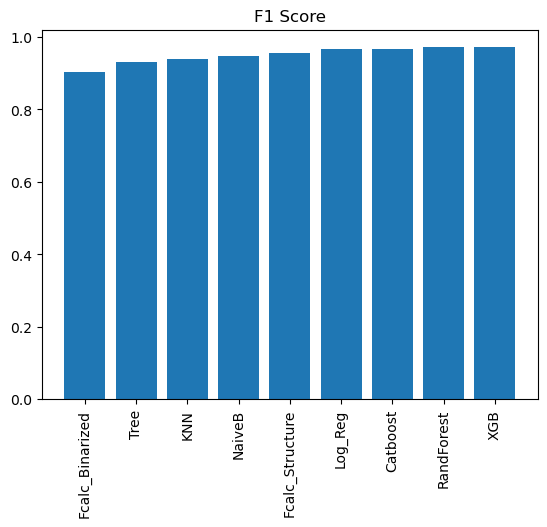

In [27]:
import operator
all_accs = [ f1_fcalc
            ,f1_fcalc_stru
            ,f1_tree
            ,f1_forest
            ,f1_knn
            ,f1_log
            ,f1_xgb
            ,f1_cat
            ,f1_bay]
all_accs_names = [ 
             'Fcalc_Binarized'
            ,'Fcalc_Structure'
            ,'Tree'
            ,'RandForest'
            ,'KNN'
            ,'Log_Reg'
            ,'XGB'
            ,'Catboost'
            ,'NaiveB']

my_dict = dict(zip(all_accs_names, all_accs))
sorted_accs = dict(sorted(my_dict.items(), key=operator.itemgetter(1)))

lists = sorted_accs.items() 
x, y = zip(*lists)

print('F1_Score\n-------------------')
for i in lists:
    print(i[0],': ', round(i[1],2), sep='')
    
plt.bar(x = x, height=y)
plt.xticks(rotation=90)
plt.title('F1 Score');